In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Load my Data

In [13]:
df = pd.read_feather("E120_2022_wg.feather")
df.head()

,Timestamp,ACC_BF5_55_E120,ACC_BF4_80_E120,ACC_BF3_80_E120,ACC_BF2_55_E120,ACC_BF1_00_E120,BF1_00_E120,BF2_20_E120,BF3_35_E120
0,2022-01-01 00:00:00,8.2,8.8,3.3,3.2,3.0,13.35,10.45,17.38
1,2022-01-01 00:15:00,7.9,9.1,3.4,3.2,3.0,13.11,10.62,17.35
2,2022-01-01 00:30:00,7.9,9.1,3.5,3.2,3.1,13.07,10.66,17.21
3,2022-01-01 00:45:00,8.0,8.8,3.4,3.2,3.1,13.31,10.52,17.38
4,2022-01-01 01:00:00,7.9,8.9,3.3,3.1,3.3,13.23,10.66,17.37


In [23]:
df.shape

(77921, 9)

In [14]:
# numpy.ndarray
df["ACC-BF5-55-E120".replace("-", "_")].values

array([8.2, 7.9, 7.9, ..., 7.5, 6.6, 7.4])

## Discrete Fourier Transform (DFT)

In [15]:
# ACC-BF4-80-E120 ist ab Mitte August 2023 größtenteils komplett kaputt

# ACC-BF5-55-E120 hat Mitte August 2023 bis Mitte Oktober 2023 extrem starke Ausschläge
# bei BF1-00-E120 sind sie weniger Stark aber trotzdem blöd und müssen raus
# vergleich zu ACC-BF2-55-E120 da sind die nur super klein die Ausschläge und der Sensor hat fast konstante Wassergehalte über die Jahre
# x = np.array([1,2,3,4,5,6,7,8,9,8,7,6,5,4,3,2,1])
x = df["ACC-BF5-55-E120".replace("-", "_")].values


x_dft = np.fft.fft(x)

In [16]:
x_dft

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

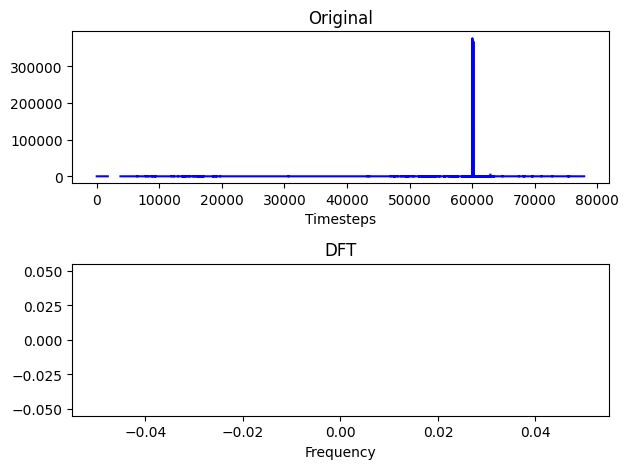

In [17]:
freq = np.fft.fftfreq(x.shape[-1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1.plot(x, color='blue')
ax1.set_xlabel('Timesteps')
ax1.set_title('Original')

ax2.plot(freq[1:], x_dft.real[1:], color='orange')
ax2.set_xlabel('Frequency')
ax2.set_title('DFT')

plt.tight_layout()

In [18]:
x = np.array([1.1,2.4,3.9,4.2])
x_dft = np.fft.fft(x)

x_dft

array([11.6+0.j , -2.8+1.8j, -1.6+0.j , -2.8-1.8j])

## Individual BOSS

In [19]:
from sktime.datasets import load_basic_motions

X_train, y_train = load_basic_motions(split='train', return_type='numpy3D')
X_test, y_test = load_basic_motions(split='test', return_type='numpy3D')

uni_X_train = X_train[:, 0:1, :]
uni_X_test = X_test[:, 0:1, :]

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score

from sktime.classification.dictionary_based import IndividualBOSS

boss = IndividualBOSS(n_jobs=-1, random_state=42)

params = {
    'window_size': [10, 20, 30],
    'word_length': [2,3,4],
    'alphabet_size': [2,3,4]
}

tuned_boss = GridSearchCV(
    boss,
    params,
    cv=KFold(n_splits=4)
)

tuned_boss.fit(uni_X_train, y_train)
y_pred = tuned_boss.predict(uni_X_test)

print(tuned_boss.best_params_)
print(accuracy_score(y_test, y_pred))

{'alphabet_size': 2, 'window_size': 10, 'word_length': 2}
0.575


## BOSS Ensemble

In [21]:
import time
from sktime.classification.dictionary_based import BOSSEnsemble

start = time.time()

boss = BOSSEnsemble(n_jobs=-1, random_state=42)

params = {
    'alphabet_size': [2,3,4],
    'feature_selection': ["chi2", "random"]
}

tuned_boss = GridSearchCV(
    boss,
    params,
    cv=KFold(n_splits=4)
)

tuned_boss.fit(uni_X_train, y_train)
y_pred = tuned_boss.predict(uni_X_test)

end = time.time()

print(f"Elapsed time: {round(end-start,0)} seconds or {round((end-start)/60,0)} minutes")
print(tuned_boss.best_params_)
print(accuracy_score(y_test, y_pred))

Elapsed time: 421.0 seconds or 7.0 minutes
{'alphabet_size': 2, 'feature_selection': 'chi2'}
0.975


## cBOSS

In [22]:
from sktime.classification.dictionary_based import ContractableBOSS

start = time.time()

c_boss = ContractableBOSS(n_jobs=-1, random_state=42)

params = {
    'min_window': [5,10,20],
    'feature_selection': ["chi2", "random"]
}

tuned_boss = GridSearchCV(
    c_boss,
    params,
    cv=KFold(n_splits=4)
)

tuned_boss.fit(uni_X_train, y_train)
y_pred = tuned_boss.predict(uni_X_test)

end = time.time()

print(f"Elapsed time: {round(end-start,0)} seconds or {round((end-start)/60,0)} minutes")
print(tuned_boss.best_params_)
print(accuracy_score(y_test, y_pred))

Elapsed time: 406.0 seconds or 7.0 minutes
{'feature_selection': 'chi2', 'min_window': 5}
0.975
